In [23]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import tensorflow as tf
import keras
import keras_tuner as kt
import torch

In [24]:
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)

In [25]:
# Check if MPS is available
if tf.config.list_physical_devices('GPU'):
    try:
        # Specify the MPS device
        tf.config.experimental.set_visible_devices(
            tf.config.list_physical_devices('GPU'), 'GPU'
        )
        logical_devices = tf.config.list_logical_devices('GPU')
        print(len(logical_devices), "Logical GPU(s) found")
        # Verify if MPS is enabled
        print("TensorFlow is using MPS")
    except RuntimeError as e:
        # If MPS is not available, fall back to CPU
        print(e)
else:
    print("MPS device not found, using CPU instead.")

# Rest of your TensorFlow code goes here, and will run on the specified device
# Example:
a = tf.constant([[1.0, 2.0], [3.0, 4.0]])
b = tf.constant([[5.0, 6.0], [7.0, 8.0]])
c = tf.matmul(a, b)
print(c)

1 Logical GPU(s) found
TensorFlow is using MPS
tf.Tensor(
[[19. 22.]
 [43. 50.]], shape=(2, 2), dtype=float32)


# Load Data

In [27]:
# Generate data paths with labels
data_dir = 'Data/Weather_Dataset'
filepaths = []
labels = []

folds = os.listdir(data_dir)
for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Filepath_series = pd.Series(filepaths, name= 'filepaths')
Label_series = pd.Series(labels, name='labels')
df = pd.concat([Filepath_series, Label_series], axis= 1)

df.head()


,filepaths,labels
0,Data/Weather_Dataset/lightning/2100.jpg,lightning
1,Data/Weather_Dataset/lightning/2114.jpg,lightning
2,Data/Weather_Dataset/lightning/2128.jpg,lightning
3,Data/Weather_Dataset/lightning/1838.jpg,lightning
4,Data/Weather_Dataset/lightning/1964.jpg,lightning


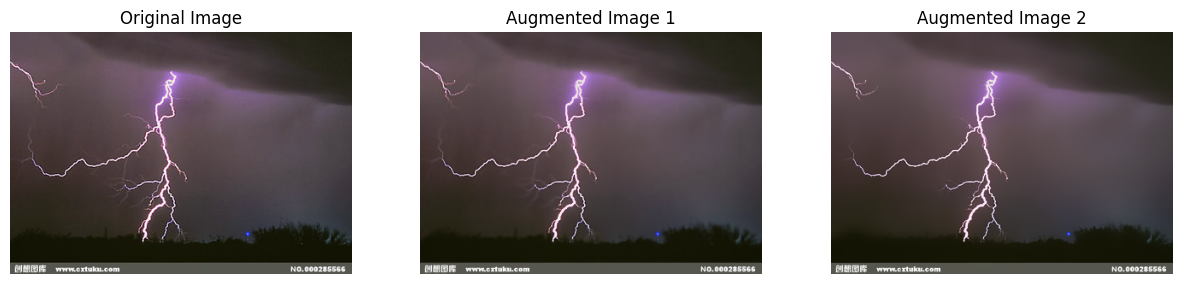

In [5]:
image = cv2.imread('Data/Weather_Dataset/lightning/2100.jpg')
augmented_image1 = cv2.bilateralFilter(image, 5, 75, 75)
augmented_image2 = cv2.bilateralFilter(image, 20, 50, 50)


# Display the images using matplotlib
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(augmented_image1)
plt.title("Augmented Image 1")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(augmented_image2)
plt.title("Augmented Image 2")
plt.axis('off')

plt.show()

{'dew': [5111], 'fogsmog': [3753], 'frost': [3294], 'glaze': [1024], 'hail': [4550], 'lightning': [0], 'rain': [1655], 'rainbow': [5798], 'rime': [2157], 'sandstorm': [362], 'snow': [6025]}


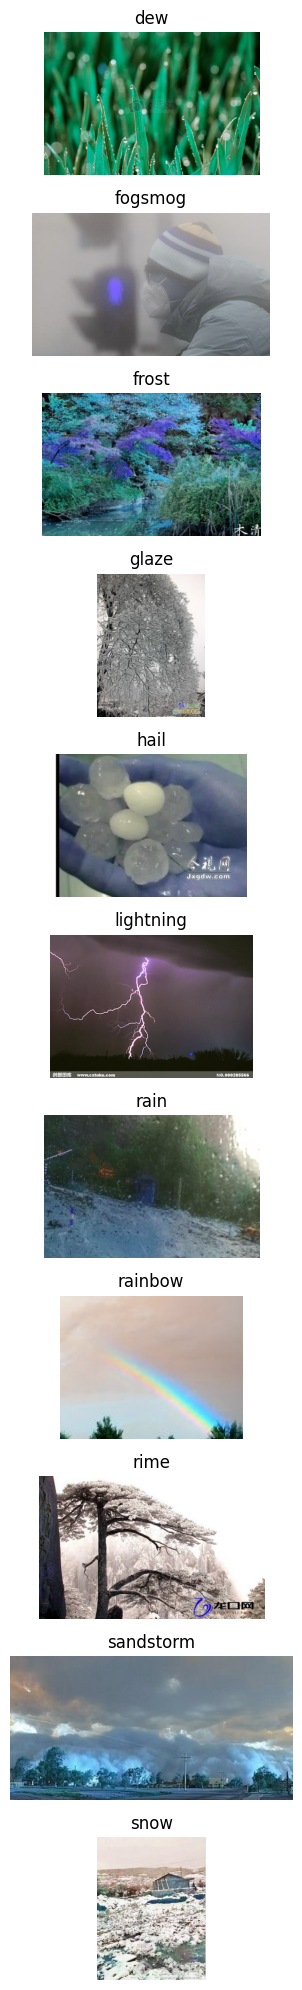

In [46]:
# Exploring first 5 images of each class from X_train
first_5_indeces_per_class = {i: [] for i in ('dew', 'fogsmog', 'frost', 'glaze', 'hail', 'lightning', 'rain', 'rainbow', 'rime', 'sandstorm', 'snow')}
for index, label in enumerate(df['labels']):
    if len(first_5_indeces_per_class[label]) < 1:
        first_5_indeces_per_class[label].append(index)
    if all(len(first_5_indeces_per_class[i]) == 1 for i in ('dew', 'fogsmog', 'frost', 'glaze', 'hail', 'lightning', 'rain', 'rainbow', 'rime', 'sandstorm', 'snow')):
        break

print(first_5_indeces_per_class)

fig, axes = plt.subplots(11, 1, figsize=(15, 20))
for i, label in enumerate(('dew', 'fogsmog', 'frost', 'glaze', 'hail', 'lightning', 'rain', 'rainbow', 'rime', 'sandstorm', 'snow')):
    for j, index in enumerate(first_5_indeces_per_class[label]):
        axes[i].imshow(cv2.imread(df['filepaths'][index]))
        axes[i].set_title(label)
        axes[i].axis('off')
plt.tight_layout()
plt.show()

# Delete corrupted image paths

In [6]:
num_skipped = 0
for folder_name in ('dew', 'fogsmog', 'frost', 'glaze', 'hail', 'lightning', 'rain', 'rainbow', 'rime', 'sandstorm', 'snow'):
    folder_path = os.path.join("Data/Weather_Dataset", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = b"JFIF" in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print(f"Deleted {num_skipped} images.")

Deleted 0 images.


In [10]:
def try_shape(shape):


    dew, fogsmog, frost, glaze, hail, lightning, rain, rainbow, rime, sandstorm, snow = [] ,[], [], [], [], [], [], [], [], [], []
    labels = []
    def process_images(folder, image_list):
        for image in os.listdir(folder):
            path = os.path.join(folder, image)
            img = cv2.imread(path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # change color from BGR to RGB
            img = cv2.copyMakeBorder(img, 50, 50, 50, 50, cv2.BORDER_CONSTANT, value=[255, 255, 255]) # add padding
            if img is not None:
                img = cv2.resize(img, shape)
                image_list.append(img)
                labels.append(folder.split("/")[-1])
            else:
                print(f"Warning: Unable to read image {path}")

    folders = ['dew', 'fogsmog', 'frost', 'glaze', 'hail', 'lightning', 'rain', 'rainbow', 'rime', 'sandstorm', 'snow']
    i = 0
    for images in [dew, fogsmog, frost, glaze, hail, lightning, rain, rainbow, rime, sandstorm, snow]:
        process_images(str("Data/Weather_Dataset/" + folders[i]), images)
        i += 1

    data = np.concatenate((np.asarray(dew),
                        np.asarray(fogsmog),
                        np.asarray(frost),
                        np.asarray(glaze),
                        np.asarray(hail),
                        np.asarray(lightning),
                        np.asarray(rain),
                        np.asarray(rainbow),
                        np.asarray(rime),
                        np.asarray(sandstorm),
                        np.asarray(snow)
                        ), axis=0)
    label_data = {'labels': labels}
    label_data_df = pd.DataFrame(label_data)
    encoder = OneHotEncoder()
    encoded_labels = encoder.fit_transform(np.array(labels).reshape(-1,1)).toarray()
    print(label_data_df.iloc[0], encoded_labels[0], encoder.inverse_transform(encoded_labels[0].reshape(1,-1))[0][0])
    np.random.seed(1234)
    shuffled_indices = np.random.permutation(range(len(data)))
    X = data[shuffled_indices]
    Y = encoded_labels[shuffled_indices]
    X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.4, random_state=1234)
    X_test, X_val, Y_test, Y_val = train_test_split(X_val, Y_val, test_size=0.5, random_state=1234)

    scaler = MinMaxScaler() # scale pixel values between 0 and 1
    X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
    X_val = scaler.transform(X_val.reshape(-1, X_train.shape[-1])).reshape(X_val.shape)
    X_test = scaler.transform(X_test.reshape(-1, X_train.shape[-1])).reshape(X_test.shape)

    X_train = X_train.reshape(X_train.shape[0], shape[0],shape[1],3)
    X_val = X_val.reshape(X_val.shape[0], shape[0],shape[1],3)
    X_test = X_test.reshape(X_test.shape[0], shape[0],shape[1],3)

    X_train = X_train.reshape(X_train.shape[0], -1)
    X_val = X_val.reshape(X_val.shape[0], -1)
    X_test = X_test.reshape(X_test.shape[0], -1)
    
    return data, labels, X_train, X_val, X_test, Y_train, Y_val, Y_test

data, labels, X_train, X_val, X_test, Y_train, Y_val, Y_test = try_shape((64, 64))

labels    dew
Name: 0, dtype: object [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] dew


# Encode Labels

In [11]:
# Part 3, print the shape of X_train and X_test
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(3962, 12288)
(1321, 12288)
(1321, 12288)


In [12]:
def build_model(num_features, learning_rate):
  """Build a TF logistic regression model using Keras.

  Args:
    num_features: The number of input features.
    learning_rate: The desired learning rate for SGD.

  Returns:
    model: A tf.keras model (graph).
  """
  # This is not strictly necessary, but each time you build a model, TF adds
  # new nodes (rather than overwriting), so the colab session can end up
  # storing lots of copies of the graph when you only care about the most
  # recent. Also, as there is some randomness built into training with SGD,
  # setting a random seed ensures that results are the same on each identical
  # training run.
  tf.keras.backend.clear_session()
  tf.random.set_seed(0)

  # Build a model using keras.Sequential. While this is intended for neural
  # networks (which may have multiple layers), we want just a single layer for
  # binary logistic regression.
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Dense(
      units=11,                     # output dim
      input_shape=[num_features],  # input dim
      use_bias=True,               # use a bias (intercept) param
      activation='softmax',     # softmax activation function for mutliclass classification
      kernel_initializer=tf.ones_initializer,  # initialize params to 1
      bias_initializer=tf.ones_initializer,    # initialize bias to 1
  ))

  # We need to choose an optimizer. We'll use SGD, which is actually mini-batch GD
  optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)

  # Finally, compile the model. Select the accuracy metric. This finalizes the graph for training.
  model.compile(optimizer=optimizer, loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['categorical_accuracy'])  # Categorical cross entropy (multiclass log loss)

  return model

In [13]:
def convert_shape_scale(shape, other_shape):
    n_pixels = other_shape[0] * other_shape[1]
    aspect_ratio = shape[1] / shape[0]
    height = int(np.sqrt(n_pixels / aspect_ratio))
    width = int(aspect_ratio * height)
    return (height, width)


shapes = {"Small": (32, 32), 
          "Max Ratio": convert_shape_scale((3174, 4863), (224, 224)),
          "98 Percentile Ratio": convert_shape_scale((1099, 1289), (224, 224)),
          "Min Pad% Ratio": convert_shape_scale((1363, 2036), (224, 224))
}
other_shapes =           {"Original": (256, 256),
          "ResNet": (224, 224)}
shape_results = {}
for description, shape in shapes.items():
    print(f"Training with shape {shape}")
    data, labels, X_train, X_val, X_test, Y_train, Y_val, Y_test = try_shape(shape)
    tf.random.set_seed(1234)
    tf.keras.backend.clear_session()
    # Build and compile model
    model_tf = build_model(X_train.shape[1], learning_rate=0.0001)

    model_tf_history = model_tf.fit(X_train, Y_train, epochs=20, batch_size=32, validation_data=(X_val, Y_val))
    shape_results[description] = {"shape": shape, "model": model_tf, "history": model_tf_history.history}

Training with shape (32, 32)
labels    dew
Name: 0, dtype: object [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] dew
Epoch 1/20


/Users/danielcosta/.pyenv/versions/3.11.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-02-20 17:26:17.869455: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - categorical_accuracy: 0.1669 - loss: 2.3462 - val_categorical_accuracy: 0.1605 - val_loss: 2.3101
Epoch 2/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - categorical_accuracy: 0.1825 - loss: 2.2781 - val_categorical_accuracy: 0.1605 - val_loss: 2.2886
Epoch 3/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - categorical_accuracy: 0.1828 - loss: 2.2548 - val_categorical_accuracy: 0.1612 - val_loss: 2.2686
Epoch 4/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - categorical_accuracy: 0.1875 - loss: 2.2339 - val_categorical_accuracy: 0.1764 - val_loss: 2.2494
Epoch 5/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - categorical_accuracy: 0.2016 - loss: 2.2143 - val_categorical_accuracy: 0.1938 - val_loss: 2.2311
Epoch 6/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - categorical_accuracy: 0.2216 - loss: 2.1955 - val_categorical_accuracy: 0.2135 - val_loss: 2.2135
Epoch 7/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - categorical_accuracy: 0.2399 - loss: 2

/Users/danielcosta/.pyenv/versions/3.11.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - categorical_accuracy: 0.2290 - loss: 2.1902 - val_categorical_accuracy: 0.3823 - val_loss: 1.8544
Epoch 2/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - categorical_accuracy: 0.4202 - loss: 1.7801 - val_categorical_accuracy: 0.4383 - val_loss: 1.7026
Epoch 3/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - categorical_accuracy: 0.4702 - loss: 1.6324 - val_categorical_accuracy: 0.4179 - val_loss: 1.6660
Epoch 4/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - categorical_accuracy: 0.4916 - loss: 1.5491 - val_categorical_accuracy: 0.4837 - val_loss: 1.5806
Epoch 5/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - categorical_accuracy: 0.5096 - loss: 1.4975 - val_categorical_accuracy: 0.4928 - val_loss: 1.5508
Epoch 6/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - categorical_accuracy: 0.5301 - loss: 1.4612 - val_categorical_accuracy: 0.5011 - val_loss: 1.5199
Epoch 7/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - categorical_accuracy: 0.538

/Users/danielcosta/.pyenv/versions/3.11.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - categorical_accuracy: 0.2321 - loss: 2.1904 - val_categorical_accuracy: 0.3815 - val_loss: 1.8539
Epoch 2/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - categorical_accuracy: 0.4212 - loss: 1.7797 - val_categorical_accuracy: 0.4406 - val_loss: 1.7016
Epoch 3/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - categorical_accuracy: 0.4695 - loss: 1.6329 - val_categorical_accuracy: 0.4088 - val_loss: 1.6739
Epoch 4/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - categorical_accuracy: 0.4904 - loss: 1.5494 - val_categorical_accuracy: 0.4807 - val_loss: 1.5821
Epoch 5/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - categorical_accuracy: 0.5145 - loss: 1.4965 - val_categorical_accuracy: 0.4951 - val_loss: 1.5461
Epoch 6/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - categorical_accuracy: 0.5270 - loss: 1.4591 - val_categorical_accuracy: 0.5026 - val_loss: 1.5211
Epoch 7/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - categorical_accuracy: 0.539

/Users/danielcosta/.pyenv/versions/3.11.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - categorical_accuracy: 0.2315 - loss: 2.1899 - val_categorical_accuracy: 0.3861 - val_loss: 1.8521
Epoch 2/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - categorical_accuracy: 0.4207 - loss: 1.7786 - val_categorical_accuracy: 0.4444 - val_loss: 1.7001
Epoch 3/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - categorical_accuracy: 0.4715 - loss: 1.6319 - val_categorical_accuracy: 0.4239 - val_loss: 1.6576
Epoch 4/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - categorical_accuracy: 0.4905 - loss: 1.5486 - val_categorical_accuracy: 0.4852 - val_loss: 1.5766
Epoch 5/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - categorical_accuracy: 0.5104 - loss: 1.4968 - val_categorical_accuracy: 0.4943 - val_loss: 1.5458
Epoch 6/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - categorical_accuracy: 0.5298 - loss: 1.4598 - val_categorical_accuracy: 0.5110 - val_loss: 1.5119
Epoch 7/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - categorical_accuracy: 0.538

In [22]:
for description, results in shape_results.items():
    print(f"Results for {description}:")
    print(f"Shape: {results['shape']}")
    print(f"Accuracy: {results['history']['categorical_accuracy'][-1]}")

Results for Small:
Shape: (32, 32)
Accuracy: 0.3546188771724701
Results for Max Ratio:
Shape: (180, 275)
Accuracy: 0.5890964269638062
Results for 98 Percentile Ratio:
Shape: (206, 241)
Accuracy: 0.5885916352272034
Results for Min Pad% Ratio:
Shape: (183, 273)
Accuracy: 0.587329626083374
Results for Original:
Shape: (256, 256)
Accuracy: 0.5888440012931824


In [18]:
shape = (256, 256)
print(f"Training with shape {shape}")
data, labels, X_train, X_val, X_test, Y_train, Y_val, Y_test = try_shape(shape)
tf.random.set_seed(1234)
tf.keras.backend.clear_session()
# Build and compile model
model_tf = build_model(X_train.shape[1], learning_rate=0.0001)

model_tf_history = model_tf.fit(X_train, Y_train, epochs=20, batch_size=32, validation_data=(X_val, Y_val))
shape_results["Original"] = {"shape": shape, "model": model_tf, "history": model_tf_history.history}

Training with shape (256, 256)
labels    dew
Name: 0, dtype: object [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] dew


/Users/danielcosta/.pyenv/versions/3.11.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - categorical_accuracy: 0.2343 - loss: 2.1783 - val_categorical_accuracy: 0.3649 - val_loss: 1.8404
Epoch 2/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - categorical_accuracy: 0.4154 - loss: 1.7596 - val_categorical_accuracy: 0.4330 - val_loss: 1.6689
Epoch 3/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - categorical_accuracy: 0.4677 - loss: 1.6146 - val_categorical_accuracy: 0.4141 - val_loss: 1.6701
Epoch 4/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - categorical_accuracy: 0.4925 - loss: 1.5492 - val_categorical_accuracy: 0.4292 - val_loss: 1.6216
Epoch 5/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - categorical_accuracy: 0.5074 - loss: 1.4909 - val_categorical_accuracy: 0.4656 - val_loss: 1.5608
Epoch 6/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - categorical_accuracy: 0.5205 - loss: 1.4496 - val_categorical_accuracy: 0.4815 - val_loss: 1.5278
Epoch 7/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - categorical_accuracy: 0.537

In [ ]:
training_loss = model_tf_history.history['loss']
validation_loss = model_tf_history.history['val_loss']
epochs = range(1, len(training_loss) + 1)

plt.plot(epochs, training_loss, label='Training Loss')
plt.plot(epochs, validation_loss, label='Validation Loss')
plt.title('Loss vs. Epochs')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

# Evaluate the Model

In [ ]:
train_loss = model_tf.evaluate(X_train, Y_train)
val_loss = model_tf.evaluate(X_val, Y_val)

print(f"Training loss: {train_loss}")
print(f"Validation loss: {val_loss}")

In [ ]:
Y_val_pred = model_tf.predict(x=X_val)
Y_val_labels = np.argmax(Y_val, axis=1)
# Get the class with the highest probability for each sample
Y_val_pred_classes = np.argmax(Y_val_pred, axis=1)
print(len(Y_val_labels), len(Y_val_pred_classes))
conf_matrix=confusion_matrix(Y_val_labels, Y_val_pred_classes)
# Plot confusion matrix
plot_labels = [f"{encoder.categories_[0][i]}" for i in range(11)]
display = ConfusionMatrixDisplay(conf_matrix, display_labels=plot_labels)
display.plot()
plt.title("Validation Dataset Confusion Matrix")
plt.yticks(fontsize=8)
plt.xticks(fontsize=8, rotation=25)
plt.show()

# Printing True Positives (TP), False Negatives (FN), False Positives (FP), and True Negatives (TN)
print(f"Len of X_val: {len(X_val)}")



# Subgroup Accuracy

In [ ]:
# YOUR CODE HERE
# Get true class label indices
def subgroup_accuracy(labels, preds):
    print(f"Overall model accuracy score: {accuracy_score(labels, preds)}")
    print(f"Overall model precision score: {precision_score(labels, preds, average='macro')}")
    print(f"Overall model recall score: {recall_score(labels, preds, average='macro')}")
    print(f"Overall model F1 score: {f1_score(labels, preds, average='macro')}\n")
    
    subgroup_accuracies = {}
    for i in np.unique(labels):
        # Get true label indices
        class_label_indices = np.where(labels == i)[0]
        # Get predicted labels for those indices
        class_label_preds = preds[class_label_indices]
        # Calculate accuracy for this class
        class_label_accuracy = len(np.where(class_label_preds==i)[0]) / len(class_label_indices)
        # Get the name of the class label
        one_hot_vector = np.eye(len(encoder.categories_[0]))[i].reshape(1, -1)
        class_label_name = encoder.inverse_transform(one_hot_vector)[0][0]
        # Add to dictionary
        subgroup_accuracies[f"Subgroup accuracy for {class_label_name}"] = np.round(class_label_accuracy,2)
    
    # Sort subgroup accuracies and print
    subgroup_accuracies = dict(sorted(subgroup_accuracies.items(), key=lambda x: x[1], reverse=True))
    for label, accuracy in subgroup_accuracies.items():
        print(f"{label}: {accuracy}")
    
print("Validation dataset evaluation metrics:\n")
subgroup_accuracies = subgroup_accuracy(Y_val_labels, np.argmax(Y_val_pred,axis=1))

In [ ]:
print(classification_report(Y_val_labels, np.argmax(Y_val_pred, axis=1), target_names=np.unique(decoded_labels)))

## Feed Forward Neural Network